In [ ]:
#attach your Google drive to read write file
#drive.mount('/content/drive')

In [9]:
## Importing the libraries:
import os, sys

import cachetools.func

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

#WHO Health Observatory API wrapper

Below is a python code that you can use to get health related data for any country in the world from World Health Organisation (WHO). To learn more about the description of the data available there check their [Global Health Observatory](https://www.who.int/data/gho) page. In particular, you can refer to the [indicators](https://www.who.int/data/gho/data/indicators) and [Data API](https://www.who.int/data/gho/info/gho-odata-api) pages.

In [2]:
def print_full(x):
  '''
  This is to print nicely DataFrame wide tables
  '''
  pd.set_option('display.max_rows', len(x))
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', 2000)
  pd.set_option('display.float_format', '{:20,.2f}'.format)
  pd.set_option('display.max_colwidth', -1)
  print(x)
  pd.reset_option('display.max_rows')
  pd.reset_option('display.max_columns')
  pd.reset_option('display.width')
  pd.reset_option('display.float_format')
  pd.reset_option('display.max_colwidth')

def agegrp_func(x):
  '''
  Function to format how age group is presented
  WHO uses AGE20-30, we want just 20-30
  '''
  if 'AGELT1' in x:
    y = '0-1'
  elif 'AGE85' in x:
    y = '85+'
  else:
    y=x.replace('AGE','')

  return y

def agegrp_mid(x):
  '''
  Function to calculate the mid age of an age group
  '''
  if 'AGELT1' in x:
    y = -3
  elif 'AGE85' in x:
    y = 87
  else:
    try:
      y=int(np.mean([int(i) for i in x.replace('AGE','').split('-')]))
    except:
      y = int(x.replace('AGE','').split('-')[0])
  return y  

class whoapi():
  '''
  This class defines methods to get data from World Health Organisation (WHO) API
  The different WHO health and related data is structured by country and indicator id (ids) 
  For example 
    Country = ETH
    indicatorid='LIFE_0000000029' 
  describes the probability of dying in age groups for Ethiopia
  Reference: for more information about available WHO data, refer
  https://www.who.int/data/gho  
  '''
  def __init__(self, dim='GHO',**kwargs):
    #
    self.url = f"http://apps.who.int/gho/athena/api/{dim}"
    self.verbose = kwargs.get('verbose',0)

  @staticmethod
  def age_sex_stem(df):    
    '''
    To nicely format AGE and SEX columns
    '''
    if 'AGEGROUP' in df.columns:
      df['MidAge'] = df['AGEGROUP'].map(agegrp_mid)
      df['AGEGROUP'] = df['AGEGROUP'].map(agegrp_func)       
      df = df.sort_values('MidAge').reset_index().drop(columns=['index'])
      
    if 'SEX' in df.columns:
      df['SEX'] = df['SEX'].map(lambda x:{'MLE':'Male',
                                              'FMLE':'Female',
                                              'BTSX':'Both'}.get(x,x))
    return df    

  def get_ids(self,s):
    df = self.dfid

    name = s
    if isinstance(s,str):
      name = [s]    

    dflist = [] 
    for d in name:
      dflist.append(df[df['id'].map(lambda x : d in x)])

    #try:
    df = pd.concat(dflist)
    #except:
    #  df = pd.DataFrame()

    return df

  def get_gho_data(self, id, fdict=None, 
                   url=None,verbose=None):
    '''
    given 
      id: indicator id, 
      fdict: dictionary of filters e.g {'COUNTRY':ETH,'YEAR':2016} ethiopian data from 2016
      url (optional)
      verbose: feedback level (0 -  less info to print; >=2 debug mode)
    get data from WHO server and return it as pandas DataFrame 
    '''
    #
    verbose = self.verbose if verbose is None else verbose
    #
    ids = id
    if isinstance(id,list):
      ids = ','.join(id)

    if url is None:
      url = f"{self.url}/{ids}.csv"

    if verbose>1:
      print('API url:',url)

    if not fdict is None:
      url += '?filter=' + ";".join([f"{k}:{v}" for k, v in fdict.items()])
    
    df = pd.read_csv(url)
    df = df.dropna(axis=1, how='all')
    try:
      df = df.drop(columns=['Comments'])
      df = df.drop(columns=['Comments'])
    except:
      #print('not dropping Comments')
      pass

    return df

  def country_data(self,ids,countries=['ETH'],year=2016):    
    '''
    This is a wrapper to 
      method: get_gho_data 
    This method allows one easily to pass multiple countries in a list
    '''
    if isinstance(countries,str):
      countries = [countries]

    dflist = []
    verbose=self.verbose
    for c in countries:
      print(f'processing country={c}')
      df = self.get_gho_data(ids,fdict={'COUNTRY':c,'YEAR':year},verbose=verbose)
      print(df.shape)
      verbose += 2
      dflist.append(df)

    df = pd.concat(dflist)
    print('all_df.shape',df.shape)
    return df

  def death_rates(self,**kwargs):
    '''
    This method fetchs data for the death rate from WHO server. 
    if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
    using keyword 
      countries=[ITH, ETH, USA], 
    The data will be returned only to these countries
    '''
    name = 'LIFE_0000000029'
    try:
      return self.age_sex_stem(self.country_data(name,**kwargs))
    except:
      return self.country_data(name,**kwargs)

  def dying_prob(self,**kwargs):
    '''
    This method fetchs the probability of dying data at a given age from WHO serer  
    if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
    using keyword 
      countries=[ITH, ETH, USA], 
    The data will be returned only to these countries
    '''

    name = 'LIFE_0000000030'
    df = self.country_data(name,**kwargs)
    try:
      return self.age_sex_stem(df)
    except:
      raise
      return df                

##Challenge 1
Below we use the `whoapi` class defined above to fetch data as pandas dataframe. The following plot is produced using the data stored in `df_pd` variable defined in the next cell. 

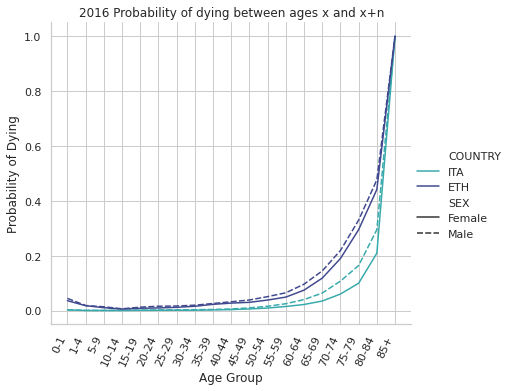


#### **Your task is to make a plot similar to this plot. You may use different colors, but the x axis labels should be rotated to make it look nice and readable. The over all quality of the plot should be as good or better than this plot. We used something like the following to the above plot**
```python
sns.set_style("ticks", {"xtick.major": len(xticks)})
with sns.axes_style("whitegrid"):
  chart = sns.relplot()
```
 
**The plot should reflect your country (use your country iso-3 three letter code) and compare it to other countries that you like. Make other useful plots if you can.**

In [3]:
'''
Here is a starter code to give you a hint
'''
#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries
df_pd = hapi.dying_prob(countries=["ETH","ITA"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

processing country=ETH
(38, 9)
processing country=ITA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (76, 9)
dying prob df.shape (76, 10)


##Challenge 2

Plot death rates as a function of age by calling the `death_rate` method. You can either use your choice of countries or use `countries=['ETH','ITA']`.

##Challenge 3

Plot the probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease. To obtain the data call the whoapi as follows 
```python
df_pd_ncd = hapi.prop_dying_ncd_3070(countries=["ETH","ITA"])
print('dying prob df.shape',df_all_ncd.shape)
```

Your plot should look as follows (but the contries being your country and multiple other contries you want to compare)

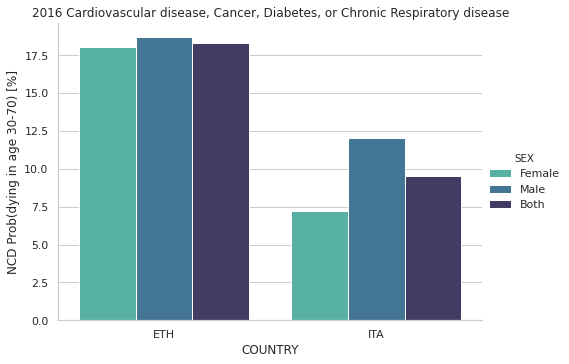



# COVID19 Data Analysis 

Below is a python class that you could use to download latest COVID19 data from John Hopkins Server for any contry in the world.

In [13]:
#-----      
#-----
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
  # fix region names
  for p in pairs:
    df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])

  return df

#-----
def merge_df_data(df1,df2):
  return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

#-----
def str_add_func(*args):      
  out = []
  for x in args:
    if isinstance(x,str):
      out.append(x)
  
  return '_'.join(out)


class covid_data():
  '''
  Python class to obtain global COVID19 data from 
  John Hopkins GIT repository. This data is updated daily, 
  and the most upto date information available on the web.  
  '''
  def __init__(self,**kwargs):

    #
    nrow = kwargs.get('nrow',None)
    self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)

  @staticmethod
  def create_ts(df):
    ts=df
    columns = ts['region']
    ts=ts.drop(['Province/State', 
                'Country/Region',
                'Lat', 
                'Long',
                'Population'], 
               axis=1).set_index('region').T    

    ts.columns = columns 
    ts=ts.fillna(0)
    #
    ts.index.name = 'Date'
    return ts

  def search_agg(self, name,col='Country/Region',ts=True):
    
    if not isinstance(name,list):
      name = [name]

    out = {}
    for k,v in {'confirmed':self.confirmed,
                'dead':self.dead,
                'recovered':self.recovered}.items():

      #pd.columns(columns=)
      df_list= []     
      for n in name:
        df = v[v[col]==n].set_index(col).filter(regex='/20')
        df_list.append(df.sum(axis=0))

      df = pd.concat(df_list,axis=1, sort=False)
      df.columns = name
      out[k] = df

      # if ts:                
      #   out[k] = self.create_ts(df)
      # else:
      #   out[k] = df.T

    return out

  def search(self, name,col='Country/Region',ts=True):
    
    if not isinstance(name,list):
      name = [name]

    out = {}
    for k,v in {'confirmed':self.confirmed,
                'dead':self.dead,
                'recovered':self.recovered}.items():
      if ts:                
        out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
      else:
        out[k] = v[v[col] in name].T
    
    return out

  @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
  def get_csseg_data(self, nrow=None):
    
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
    path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

    # 
    
    url = f'{path}/time_series_covid19_confirmed_global.csv'
    confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    #
    url = f'{path}/time_series_covid19_deaths_global.csv'
    dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    #
    url = f'{path}/time_series_covid19_recovered_global.csv'
    
    recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
    print(confirmed.head())
    #
    return confirmed, dead, recovered


## Challenge 4:
**Compare the number of COVID19 cases, deaths, and recovries with respect to your neighbouring contries**

After successfully doing this and the previous challenges, share your final nice plot on twitter by adding #10AcademyCovid19Response hashtag. Include your twitter post links in this notebook, or as a comment when you submit. 

**Your task is to produce a plot like this for your country and the neighbouring countries for #cases, #deaths, and #recoveries. Any improvement you can make is a plus.**
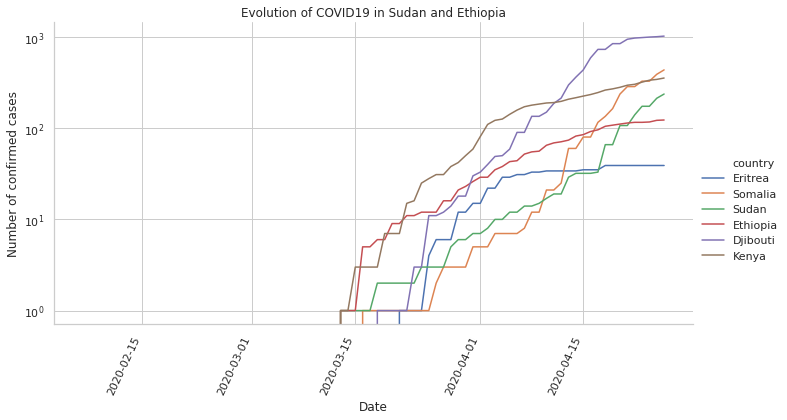

## Example

We can obtain the COVID19 number of confirmed cases, number of dead, and number of recovered counts for any subset of countries (the example below is for Ethiopia and its 5 neighbours) using the above class as follows: 

```python
cd = covid_data()
cd.confirmed.head()
countries = ['Sudan','Ethiopia','Djibouti','Kenya','Eritrea','Somalia']
mm = cd.search_agg(countries)
```
The output mm is a python dict of  #confirmed cases, #dead, and #recovered dataframes i.e `mm['dead']` is a data frame which contains countries as columns and date as rows.

You can transform the `mm` dict of dataframes into single data frame by using the following code 

```python
for ix, ctype in enumerate(['confirmed', 'dead', 'recovered']):
  df = mm[ctype].stack().reset_index()/
  #print(df.head())
  df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
  if ix==0:
    df['date'] = pd.to_datetime(df['date'])
    dfall = df
  else:
    dfall[ctype] = df[ctype]
```
If you issue `print(dfall.head())` you should get something like this
```
date	        country	       confirmed	dead	recovered
0	2020-01-22	Sudan	          0	      0	     0
1	2020-01-22	Ethiopia	       0          0	     0
2	2020-01-22	Djibouti	       0	      0	     0
3	2020-01-22	Kenya	          0	      0	     0
4	2020-01-22	Eritrea	        0	      0	     0
```

Once you have the data in the the right data frame, use groupby to get data per country, and use seaborn to do the plotting. Show plot for the all  the three i.e. cases, deaths, and recoveries 